In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy.optimize import fsolve
import casadi as ca
import matplotlib.pyplot as plt
import optuna
import time


In [52]:
np.random.seed(42)
print(np.random.seed)

# Constantes
A1 = (2.6)*(10**-3)
Lc = 2
kv = 0.38*100
P1 = 4.5
P_out = 5
C = 479

timestep = 2 # Passos no passado para prever o próximo
epochs = 15000
units = 50 # Número de Neurônios
nData = 600 # Segundos para cada alteração do Alfa
nAlphas = 5 # Número de vezes que o Alfa irá mudar, considere o treino e os testes.
alphas = np.random.uniform(0.35,0.65, nAlphas+1) # Abertura da válvula
perturb = 5e-4
tempo = 60
dt = 0.1 # Tempo amostral

# Variáveis auxiliares
interval = [np.linspace(i * tempo, (i + 1) * tempo, nData) for i in range(nAlphas)]
massFlowrate = []
PlenumPressure = []
alpha_values = []
RNN_train = []
RNN_trainFut = []

<built-in function seed>


In [59]:
# Condições Iniciais
def fun(variables, A1, Lc, kv, P1, P_out, C) :
    (x,y) = variables
    eqn_1 = (A1/Lc)* ((1.5 * P1) - y)*1e6
    eqn_2 = (C**2)/2 * (x - alphas[0] * kv * np.sqrt(y*1000 - P_out*1000))
    return [eqn_1, eqn_2]

result = fsolve(fun, (0, 10), args = (A1, Lc, kv, P1, P_out, C)) 

init_m = result[0] 
init_p = result[1]

# Variáveis CasADi
x = ca.MX.sym('x', 2)
alpha = ca.MX.sym('alpha', 1)

# Inicialize como listas
massFlowrate = []
PlenumPressure = []

# Solução Numérica
tm1 = time.time()
for i in range(nAlphas):
    alpha_values.append(np.full(nData, alphas[i]))

    rhs = ca.vertcat((A1/Lc)*((1.5 * P1) - x[1])*1e6, (C**2)/2 * (x[0] - alpha * kv * np.sqrt(x[1]*1000 - P_out*1000)))
    ode = {'x': x, 'ode': rhs, 'p': alpha}

    F = ca.integrator('F', 'idas', ode, interval[0][0], dt)

    for j in range(nData):
        sol = F(x0=[init_m, init_p], p=alpha_values[i][j])
        xf_values = np.array(sol["xf"])
        aux1, aux2 = xf_values

        
        massFlowrate.append(aux1[0])  
        PlenumPressure.append(aux2[0]) 

        init_m = aux1[-1]
        init_p = aux2[-1]
        RNN_train.append([aux1[0], aux2[0], alpha_values[i][j]])
        RNN_trainFut.append([aux1[0], aux2[0], alpha_values[i][j]])

tm2 = time.time()

# Convertendo para numpy arrays, se necessário
massFlowrate = np.array(massFlowrate).reshape(nAlphas, nData)
PlenumPressure = np.array(PlenumPressure).reshape(nAlphas, nData)

print(tm2 - tm1)

IndexError: index 500 is out of bounds for axis 0 with size 500

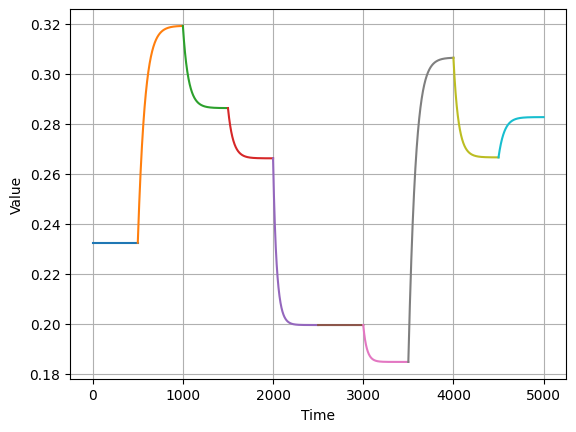

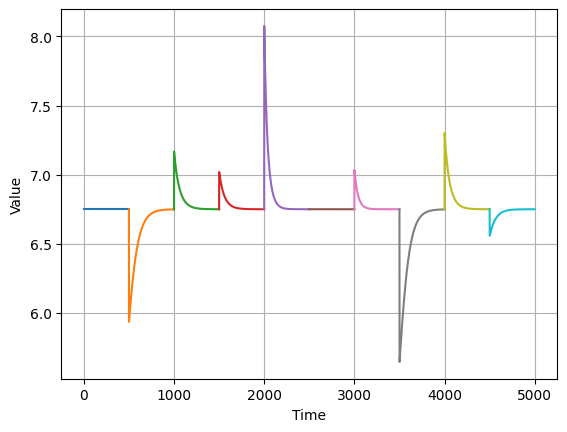

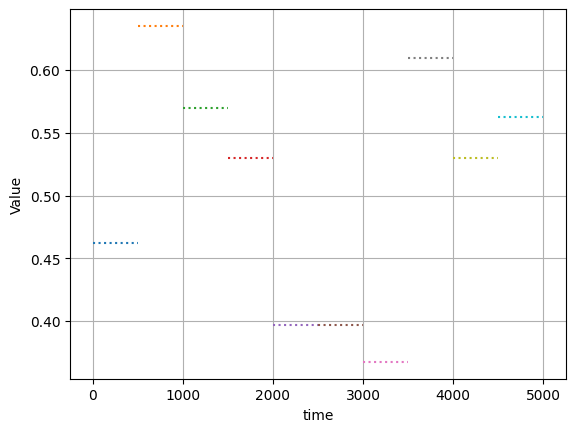

In [154]:
plt.figure("mass flow rate x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(massFlowrate[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("Plenum pressure x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(PlenumPressure[i]), label='x0(t)')
plt.grid(True)
plt.xlabel('Time')  
plt.ylabel('Value')

plt.figure("alpha x time")
for i in range(0,10):
    plt.plot(interval[i], np.squeeze(alpha_values[i]), linestyle=':')
plt.grid(True)
plt.xlabel('time') 
plt.ylabel('Value')


plt.show()


In [155]:
RNN_train = np.array(RNN_train)
RNN_trainFut = np.array(RNN_trainFut)
RNN_test = np.array(RNN_test)

X_train = []
y_train = []
x_test = []

# Nao estou gostando de ter que separar o RNN Train e RNN Test

for j in range(nAlphas_Met):
    for i in range(len(RNN_train[0][0])):
        X_train.append(RNN_train[j,:,i])
        x_test.append(RNN_test[j,:,i])
        if i == (len(RNN_train[0][0]) - 1):
            y_train.append(RNN_trainFut[j, :2, 0])
        else:
            y_train.append(RNN_train[j,:2,i+1])

newData = int((nData*nAlphas_Met)/timestep)

X_train = np.array(X_train)
y_train = np.array(y_train)
x_test = np.array(x_test)

X_train = tf.reshape(X_train, [newData,timestep,3])
y_train = tf.reshape(y_train, [newData,timestep,2])
x_test = tf.reshape(x_test, [newData,timestep,3])


In [156]:
class DynamicNormalizeLayer(keras.Layer):
    def call(self, inputs):
        batch_min = tf.reduce_min(inputs, axis=[1, 2], keepdims=True)
        batch_max = tf.reduce_max(inputs, axis=[1, 2], keepdims=True)
        return 2 * (inputs - batch_min) / (batch_max - batch_min) - 1, batch_min, batch_max

class DynamicDenormalizeLayer(keras.Layer):
    def call(self, inputs, batch_min, batch_max):
        return ((inputs + 1) / 2) * (batch_max - batch_min) + batch_min

class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.normalize_layer = DynamicNormalizeLayer()
        self.denormalize_layer = DynamicDenormalizeLayer()
        self.rnn = None  # Inicializa como None
        self.dense = None  # Inicializa como None

    def build(self, input_shape):
        # Defina a camada RNN e densa aqui
        self.rnn = keras.layers.Bidirectional(keras.layers.SimpleRNN(50, return_sequences=True, activation='tanh'))
        self.dense = keras.layers.Dense(2)

    def call(self, inputs):
        normalized_inputs, batch_min, batch_max = self.normalize_layer(inputs)
        rnn_output = self.rnn(normalized_inputs)
        dense_output = self.dense(rnn_output)
        return self.denormalize_layer(dense_output, batch_min, batch_max)

In [105]:
def lossCustom(y_true, y_pred):
    weight1 = 1
    weight2 = 1
    data_loss = tf.reduce_mean(tf.square(y_true[:, :, 0] - y_pred[:, :, 0]))* weight1 + tf.reduce_mean(tf.square(y_true[:, :, 1] - y_pred[:, :, 1]))*weight2
    return data_loss

def create_model(lr, units):
    model = MyModel()
    model.rnn = keras.layers.Bidirectional(keras.layers.SimpleRNN(units, return_sequences=True, activation='tanh'))
    model.dense = keras.layers.Dense(2)
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr), loss=lossCustom)
    return model

def objective(trial):
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True) 
    units = trial.suggest_int('units', 32, 128)
    batch_size = trial.suggest_int('batch_size', 16, 128)       

    model = create_model(lr, units)


    model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=2000, batch_size=batch_size, verbose=0)

    # Avaliação
    loss = model.evaluate(x_val, y_val, verbose=0)
    return loss

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20)  # Ajuste o número de tentativas conforme necessário

# Exibir os melhores hiperparâmetros
print("Melhores hiperparâmetros: ", study.best_params)

[I 2024-10-12 11:43:11,654] A new study created in memory with name: no-name-79cfadf7-4f47-499f-ae83-af89b9798e02
[I 2024-10-12 11:44:37,445] Trial 0 finished with value: 0.00505096884444356 and parameters: {'lr': 1.2402568881284128e-05, 'units': 126, 'batch_size': 105}. Best is trial 0 with value: 0.00505096884444356.
[I 2024-10-12 11:47:35,390] Trial 1 finished with value: 0.0005529563641175628 and parameters: {'lr': 0.0006561248259229286, 'units': 40, 'batch_size': 24}. Best is trial 1 with value: 0.0005529563641175628.
[I 2024-10-12 11:50:32,674] Trial 2 finished with value: 0.0010807628277689219 and parameters: {'lr': 8.542444787327147e-05, 'units': 108, 'batch_size': 23}. Best is trial 1 with value: 0.0005529563641175628.
[I 2024-10-12 11:52:13,045] Trial 3 finished with value: 0.005103842820972204 and parameters: {'lr': 0.028267545446180795, 'units': 32, 'batch_size': 77}. Best is trial 1 with value: 0.0005529563641175628.
[I 2024-10-12 11:54:54,956] Trial 4 finished with value:

Melhores hiperparâmetros:  {'lr': 0.0006561248259229286, 'units': 40, 'batch_size': 24}


In [157]:
model = create_model(0.0006561248259229286, 40)



early_stopping = keras.callbacks.EarlyStopping(
    monitor='loss',  
    patience=1000,     
    restore_best_weights=True 
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',  
    factor=0.5,          
    patience=100,          
    min_lr=1e-6          
)

history = model.fit(X_train, y_train, epochs=2000, verbose=1, batch_size=24, callbacks= [early_stopping, reduce_lr])

Epoch 1/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 16.4715 - learning_rate: 6.5612e-04
Epoch 2/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0169 - learning_rate: 6.5612e-04
Epoch 3/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1525e-04 - learning_rate: 6.5612e-04
Epoch 4/2000
 1/53 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 6.4512e-05

/usr/local/lib/python3.12/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - learning_rate: 6.5612e-04
Epoch 5/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0011 - learning_rate: 6.5612e-04
Epoch 6/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5403e-04 - learning_rate: 6.5612e-04
Epoch 7/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.2643e-04 - learning_rate: 6.5612e-04
Epoch 8/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.4467e-04 - learning_rate: 6.5612e-04
Epoch 9/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4.8833e-04 - learning_rate: 6.5612e-04
Epoch 10/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.5225e-04 - learning_rate: 6.5612e-04
Epoch 11/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3.1853e-04 - learning_rate: 6.5612e-04
Epoch 12/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2.5287e-04 - learning_rate: 6.5612e-04
Epoch 13/2000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6.0951e-04 - learning_rate: 6.5612e-04
Epoch 14/2000
53/53 ━━━━━━━

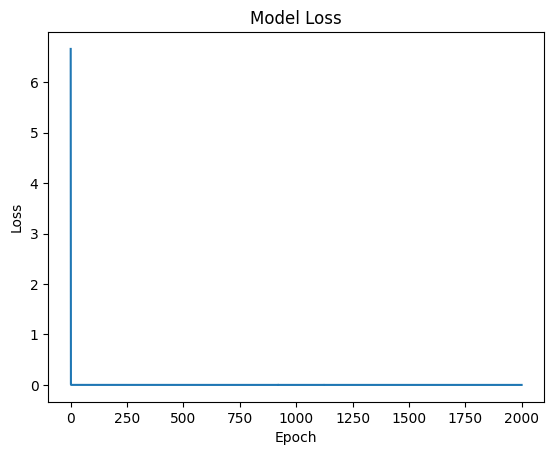

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
(1250, 2, 2)


/tmp/ipykernel_5530/3547575374.py:33: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[0].legend()
/tmp/ipykernel_5530/3547575374.py:43: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  axs[1].legend()


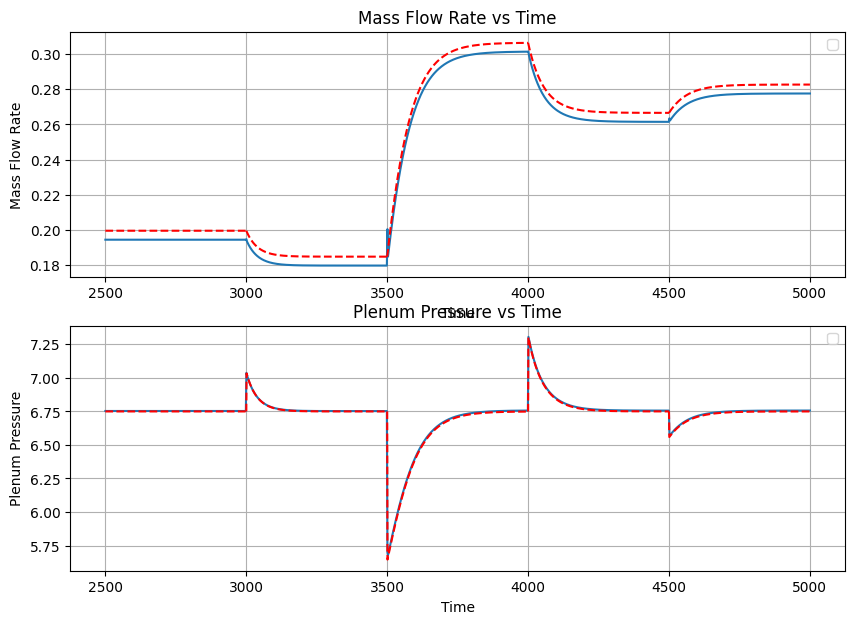

In [158]:
# Plot the training loss
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

interval2 = [np.linspace(2500, 5000, 1250)]

# Assuming X_new is the new data for prediction

prediction = model.predict(x_test)
print(prediction.shape)

# Extraindo da Predicao

mass = prediction[:,-1,0]

pressure = prediction[:, -1,1]

# Cria uma figura com subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 7), )

axs[0].plot(interval2[0], np.squeeze(mass))

# Gráfico da mass FlowRate vs. Tempo
for i in range(5, 10):
    axs[0].plot(interval[i], np.squeeze(massFlowrate[i]), 'r--')
axs[0].grid(True)
axs[0].set_xlabel('Time')
axs[0].set_ylabel('Mass Flow Rate')
axs[0].set_title('Mass Flow Rate vs Time')
axs[0].legend()

# Gráfico da Pressão do PlenumPressure vs. Tempo
axs[1].plot(interval2[0], np.squeeze(pressure))
for i in range(5, 10):
    axs[1].plot(interval[i], np.squeeze(PlenumPressure[i]), 'r--')
axs[1].grid(True)
axs[1].set_xlabel('Time')
axs[1].set_ylabel('Plenum Pressure')
axs[1].set_title('Plenum Pressure vs Time')
axs[1].legend()

